## Overview

Trong notebook này, cho phần build ANN chính mình sẽ sử dụng các thư viện:
- Numpy
- PyTorch


## Import library && data

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor, optim
import numpy as np
import torch.nn.functional as F
import seaborn as sns

In [193]:
import pandas as pd
from sklearn.model_selection import train_test_split
raw_data = pd.read_csv("../data/processed/train_normalized.csv")
train_data = raw_data.copy()
# important_features = ['Cholesterol', 'Blood_Glucose','Bone_Density', 'Vision', 'Hearing', 'Smoking_Current', 'Smoking_Former', 'Smoking_Never', 'Cognitive_Function', 'Systolic_BP', 'Diastolic_BP']
# train_data = train_data[important_features + ["Age"]]
# train_data.dtypes
x = train_data.drop(columns=["Age"])
y = train_data["Age"]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

xtrain.shape
ytrain.shape

## Building ANN class

Class này mình sẽ sử dụng Thư viện torch để tạo class và sử dụng hàm hàm kích hoạt Relu từ thư viện này

### Model class

In [194]:
import torch.nn.functional as F

class AgePredictionANN(nn.Module):
    def __init__(self):
        super(AgePredictionANN, self).__init__()
        # fc stand for fully conntection
        self.fc1 = nn.Linear(49,64)
        self.fc2 = nn.Linear(64,16)
        self.fc3 = nn.Linear(16,1)
        
    def forward(self, x):
        inputLayer1 = self.fc1(x)
        activate1 = F.relu(inputLayer1)
        
        outHiddenLayer2 = self.fc2(activate1)
        activate2 = F.relu(outHiddenLayer2)
        
        outputLayer3 = self.fc3(activate2)
        return outputLayer3

In [195]:
model = AgePredictionANN()

In [196]:
model

AgePredictionANN(
  (fc1): Linear(in_features=49, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

### Hàm mất mát và hàm cải tiến

Mục đích hai hàm này là để giúp cải thiện trọng số và bias trong model trong quá trình train model bên dưới

In [197]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Chuyển đổi dữ liệu phù hợp cho việc build model bằng thư viện Pytorch

Bởi vì thư viện Pytorch được xây dựng để build dữ liệu từ tensor - một cấu trúc dữ liệu cơ bản, tương tự như mảng (array):
- Ta sẽ tiến hành đổi dataframe dữ liệu sang numpy
- Từ numpy sẽ dễ dàng hơn để đổi qua tensor

In [198]:
xtrainNumpy = x_train.to_numpy()
ytrainNumpy = y_train.to_numpy()

In [199]:
xtrainNumpy = np.array(x_train, dtype=np.float32)
xTrainTensor = torch.tensor(xtrainNumpy, dtype=torch.float32)
xTrainTensor

tensor([[-0.9097, -0.0934,  2.2569,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0522,  0.3773, -0.8741,  ...,  0.0000,  1.0000,  0.0000],
        [-1.3095,  0.4762, -1.0307,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [-0.0391, -0.6096,  0.0704,  ...,  0.0000,  0.0000,  1.0000],
        [-1.9122,  0.9195, -0.0939,  ...,  1.0000,  0.0000,  0.0000],
        [ 1.6995,  1.4667, -0.2834,  ...,  0.0000,  0.0000,  1.0000]])

In [200]:
yTrainTensor = torch.tensor(ytrainNumpy, dtype=torch.float32)
print("Shape of xTrainTensor:", xTrainTensor.shape)
print("Shape of yTrainTensor:", yTrainTensor.shape)

Shape of xTrainTensor: torch.Size([2400, 49])
Shape of yTrainTensor: torch.Size([2400])


## Build Model

### Giải thích các biến và Cơ chế hoạt động

1. **Biến:**
   - `training_losses`: Danh sách rỗng được dùng để lưu trữ các giá trị mất mát huấn luyện cho mỗi epoch.
   - `loss_history`: Danh sách rỗng để theo dõi các giá trị mất mát qua các epoch nhằm giám sát sự hội tụ.
   - `tolerance`: Một số nguyên được đặt là 5, dùng để xác định số lượng epoch để kiểm tra sự hội tụ.
   - `xTrainTensor`: Một tensor được tạo từ mảng `xTrainNumpy`, với kiểu dữ liệu `torch.float32`. Tensor này đại diện cho các đặc trưng đầu vào cho việc huấn luyện.
   - `yTrainTensor`: Một tensor được tạo từ mảng `yTrainNumpy`, với kiểu dữ liệu `torch.float32`. Tensor này đại diện cho các giá trị mục tiêu cho việc huấn luyện.

2. **Cơ chế hoạt động:**
   - Đoạn mã chạy một vòng huấn luyện trong số lượng epoch được chỉ định (`num_epoch`).
   - Trong mỗi epoch:
     - Mô hình đưa ra dự đoán trên dữ liệu huấn luyện (`xTrainTensor`).
     - Mất mát được tính toán bằng cách sử dụng tiêu chí (hàm mất mát) giữa các giá trị dự đoán và các giá trị mục tiêu thực tế (`yTrainTensor`).
     - Các độ dốc được đặt lại bằng không bằng cách sử dụng `optimizer.zero_grad()`.
     - Mất mát được lan truyền ngược lại bằng `loss.backward()`.
     - Optimizer cập nhật các tham số của mô hình bằng `optimizer.step()`.
     - Giá trị mất mát hiện tại được chuyển đổi thành số float và được thêm vào `loss_history`.
     - Nếu độ dài của `loss_history` lớn hơn 5, mã kiểm tra xem các mất mát gần nhất (số lượng là `tolerance`) có giống nhau không. Nếu chúng giống nhau, nó in ra một thông báo cho biết việc huấn luyện đã hoàn thành và thoát khỏi vòng lặp.
     - Mất mát cho epoch hiện tại được in ra.

Đoạn mã này là một phần của vòng huấn luyện cho một mô hình mạng nơ-ron sử dụng PyTorch. Nó bao gồm các cơ chế để giám sát và có thể dừng việc huấn luyện sớm nếu mất mát không thay đổi đáng kể trong số lượng epoch được chỉ định.

In [201]:

num_epoch = 10000
training_losses = []
loss_history = []
tolerance = 5
for epoch in range(1,num_epoch+1):
    predict = model(xTrainTensor)
    loss = criterion(predict.squeeze(), yTrainTensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_loss:float = loss.item()
    loss_history.append(round(current_loss, 2))
    if len(loss_history)>5:
        if all(loss_history[-1] == last_loss for last_loss in loss_history[-tolerance-1:-1]):
            print(f"Training completed, Epoch: {epoch}, Final Loss: {current_loss:.4f}")
            break
    print(f'Epoch [{epoch}/{num_epoch}], Loss: {current_loss:.4f}')



Epoch [1/10000], Loss: 1.0050
Epoch [2/10000], Loss: 0.9844
Epoch [3/10000], Loss: 0.9646
Epoch [4/10000], Loss: 0.9451
Epoch [5/10000], Loss: 0.9260
Epoch [6/10000], Loss: 0.9072
Epoch [7/10000], Loss: 0.8883
Epoch [8/10000], Loss: 0.8692
Epoch [9/10000], Loss: 0.8496
Epoch [10/10000], Loss: 0.8294
Epoch [11/10000], Loss: 0.8084
Epoch [12/10000], Loss: 0.7867
Epoch [13/10000], Loss: 0.7641
Epoch [14/10000], Loss: 0.7407
Epoch [15/10000], Loss: 0.7163
Epoch [16/10000], Loss: 0.6910
Epoch [17/10000], Loss: 0.6649
Epoch [18/10000], Loss: 0.6380
Epoch [19/10000], Loss: 0.6104
Epoch [20/10000], Loss: 0.5821
Epoch [21/10000], Loss: 0.5532
Epoch [22/10000], Loss: 0.5237
Epoch [23/10000], Loss: 0.4939
Epoch [24/10000], Loss: 0.4638
Epoch [25/10000], Loss: 0.4337
Epoch [26/10000], Loss: 0.4038
Epoch [27/10000], Loss: 0.3745
Epoch [28/10000], Loss: 0.3460
Epoch [29/10000], Loss: 0.3187
Epoch [30/10000], Loss: 0.2927
Epoch [31/10000], Loss: 0.2683
Epoch [32/10000], Loss: 0.2458
Epoch [33/10000],

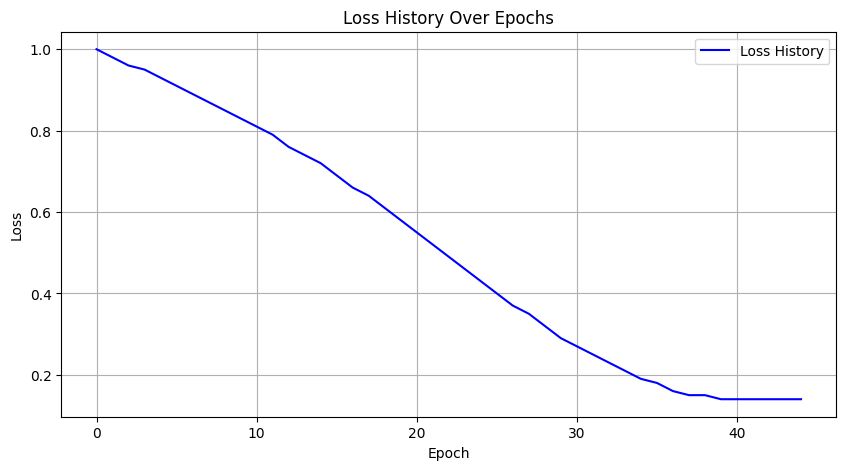

In [202]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))  
plt.plot(loss_history, label='Loss History', color='blue')  
plt.title('Loss History Over Epochs')  
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  
plt.grid()  
plt.show()  

## Asssessing the model

In [203]:

# Chuyển đổi DataFrame sang numpy arrays
X_test_numpy = x_test.to_numpy().astype(np.float32)
y_test_numpy = y_test.to_numpy().astype(np.float32)

# Chuyển đổi numpy arrays sang tensors
X_test_tensor = torch.tensor(X_test_numpy, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_numpy, dtype=torch.float32)

# Đưa mô hình vào chế độ đánh giá
model.eval()

# Thực hiện dự đoán
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze()

# Tính toán các chỉ số đánh giá
criterion = nn.MSELoss()
mse = criterion(predictions, y_test_tensor).item()

mae = nn.L1Loss()
mae_value = mae(predictions, y_test_tensor).item()

print(f"Mean Squared Error (MSE) trên dữ liệu kiểm tra: {mse:.4f}")
print(f"Mean Absolute Error (MAE) trên dữ liệu kiểm tra: {mae_value:.4f}")

Mean Squared Error (MSE) trên dữ liệu kiểm tra: 0.1315
Mean Absolute Error (MAE) trên dữ liệu kiểm tra: 0.2944


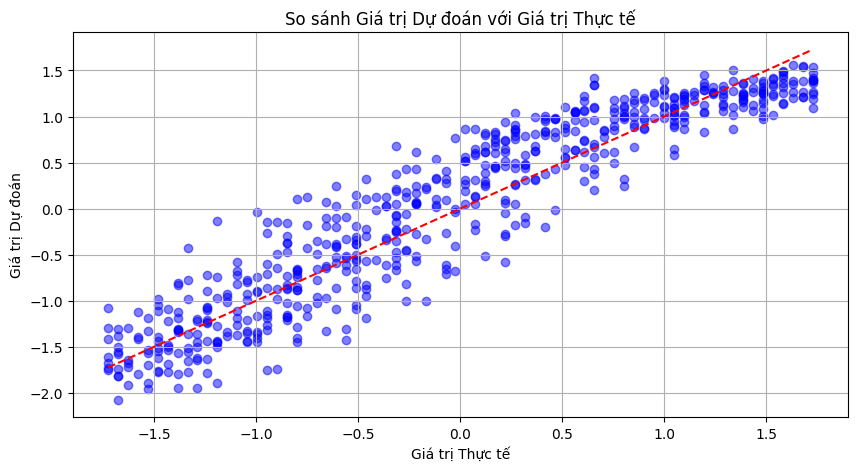

In [204]:
# So sánh dự đoán với giá trị thực tế
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_test_numpy, predictions.numpy(), color='blue', alpha=0.5)
plt.plot([y_test_numpy.min(), y_test_numpy.max()], [y_test_numpy.min(), y_test_numpy.max()], 'r--')
plt.xlabel('Giá trị Thực tế')
plt.ylabel('Giá trị Dự đoán')
plt.title('So sánh Giá trị Dự đoán với Giá trị Thực tế')
plt.grid()
plt.show()

C:\Users\21522\AppData\Local\Temp\ipykernel_9068\1950313872.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predictions.numpy(), label='Predictions', shade=True)
C:\Users\21522\AppData\Local\Temp\ipykernel_9068\1950313872.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test_numpy, label='Actual Values', shade=True)


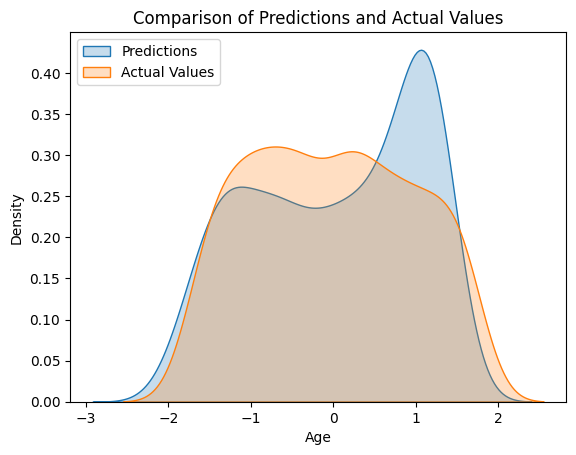

In [205]:
predictions_numpy = predictions.numpy()
y_test_numpy = y_test_tensor.numpy()

# Vẽ biểu đồ KDE cho dự đoán và giá trị thực tế
sns.kdeplot(predictions.numpy(), label='Predictions', shade=True)
sns.kdeplot(y_test_numpy, label='Actual Values', shade=True)
plt.title('Comparison of Predictions and Actual Values')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

### Thực hiện cross-validation


In [206]:
def train_model(model, xTrainTensor, yTrainTensor, optimizer, criterion, num_epoch=10000, tolerance=5):
    training_losses = []
    loss_history = []
    for epoch in range(1, num_epoch + 1):
        predict = model(xTrainTensor)
        loss = criterion(predict.squeeze(), yTrainTensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_loss = loss.item()
        loss_history.append(round(current_loss, 2))

        if len(loss_history) > tolerance:
            if all(loss_history[-1] == last_loss for last_loss in loss_history[-tolerance-1:-1]):
                print(f"Training completed, Epoch: {epoch}, Final Loss: {current_loss:.4f}")
                break

        # print(f'Epoch [{epoch}/{num_epoch}], Loss: {current_loss:.4f}')
    
    return model


In [207]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
validateion_data = train_data.copy()
x_validate = validateion_data.drop(columns=["Age"])
y_validate = validateion_data["Age"]

# Chuyển đổi toàn bộ dữ liệu x và y sang numpy và sau đó sang tensor
X_numpy = x_validate.to_numpy().astype(np.float32)
Y_numpy = y_validate.to_numpy().astype(np.float32)
X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
Y_tensor = torch.tensor(Y_numpy, dtype=torch.float32)

# Thiết lập KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []
i = 0
for train_index, test_index in kf.split(X_tensor):
    X_train, X_test = X_tensor[train_index], X_tensor[test_index]
    Y_train, Y_test = Y_tensor[train_index], Y_tensor[test_index]
    
    model = AgePredictionANN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
   

    model = train_model(model,X_train,Y_train,optimizer,criterion)

    # Đánh giá mô hình
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).squeeze()
        mse = criterion(predictions, Y_test).item()
        mae_value = mae(predictions, Y_test).item()
        r2 = r2_score(Y_test.numpy(), predictions.numpy()) 
        rmse = np.sqrt(mse)
        mse_scores.append(mse)
        mae_scores.append(mae_value)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
# In kết quả trung bình của MSE và MAE
mse_scores = pd.DataFrame(mse_scores , columns=['MSE'])
mae_scores = pd.DataFrame(mae_scores , columns=['MAE']) 
rmse_scores = pd.DataFrame(rmse_scores, columns=['RMSE'])
r2_scores = pd.DataFrame(r2_scores, columns=['R2'])
score = pd.concat([mse_scores, mae_scores,rmse_scores, r2_scores], axis=1)
score

Training completed, Epoch: 52, Final Loss: 0.1313
Training completed, Epoch: 41, Final Loss: 0.1331
Training completed, Epoch: 45, Final Loss: 0.1301
Training completed, Epoch: 51, Final Loss: 0.1248
Training completed, Epoch: 49, Final Loss: 0.1235


,MSE,MAE,RMSE,R2
0,0.126270,0.282856,0.355345,0.869670
1,0.128426,0.282754,0.358365,0.880461
2,0.135177,0.291078,0.367664,0.859540
3,0.125315,0.280667,0.353999,0.881671
4,0.133036,0.289566,0.364741,0.856474
